The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


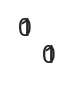

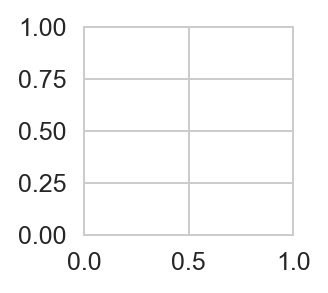

In [6]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.subplots(1,1,figsize=(1e-5, 1e-5))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('whitegrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import torch
from torch import nn
import torch.nn.functional as F
import glob
# Here you import other functions and classes
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import encode_batch, AA_KEYS, BL62_VALUES, BL62FREQ_VALUES, BL50, BL50_VALUES
from src.models import NNAlignEFSinglePass, NNAlignEFTwoStage
from src.datasets import NNAlignDataset
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import binomtest
plt.subplots(1,1,figsize=(1.5,1.5))
sns.set_palette('tab10', 6)

In [2]:
DD='../output/250218_StructAll_results_REREDONE/'
%ls ../output/250218_StructAll_results_REREDONE| head -n 3

HLA-DR_ensemble_test_baseline.csv
HLA-DR_ensemble_test_disorder_only.csv
HLA-DR_ensemble_test_mean_struct.csv


In [7]:
def get_name(fn):
    if 'ensemble_test' in fn:
        return fn.split('ensemble_test_')[1].replace('.csv','').split('_per_HLA')[0]
    elif 'valid' in fn:
        return fn.split('valid_')[1].replace('.csv','').split('_per_HLA')[0]

def read_result(fn):
    name = get_name(fn)
    return pd.read_csv(fn).assign(model=name)
    
def get_binompval(k,n, alt="greater"):
    return binomtest(k,n, alternative=alt).pvalue
    
def do_binom(df):
    bs = df.query('model=="baseline"').set_index('MHC')[['auc','auc01','ppv']]
    n = len(bs)
    results = []
    for model in [x for x in df.model.unique() if x !="baseline"]:
        tmp = df.query('model==@model').set_index('MHC')
        ks = (tmp[['auc','auc01','ppv']] > bs).sum()
        results.append(pd.DataFrame(ks.apply(get_binompval, n=n), columns=[model]).T)
    return pd.concat(results).rename(columns={k:f'{k}_pval' for k in ['auc','auc01','ppv']}).rename(index={'baseline':'Baseline', 'mean_struct':'Mean',
                 'pos_struct':'All', 'rsa_only':'RSA', 
                 'disorder_only':'Disorder', 'pq3_only':'pq3'}).loc[['Mean', 'All', 'RSA', 'Disorder', 'pq3']]

In [152]:
def make_box(df, figsize=(12,7), saturation=0.8, alpha=0.8, 
             width=0.8, size=1, swarm=False, fill=True, fn=None, od='../output/250218_StructAll_results_REREDONE/'):
    # df stuff
    fs = 16
    fw = 'semibold'
    pvals = do_binom(df)
    sigs = pvals.applymap(lambda x: 'ns' if x > 0.05 else 
                                    '****' if x <= 0.0001 else 
                                    '***' if x <= 0.001 else 
                                    '**' if x <= 0.01 else 
                                    '*')
    sigs = pd.concat([pd.DataFrame({'auc_pval':'None', 'auc01_pval':'None', 'ppv_pval':'None'}, 
                                   index=['baseline']),
                     sigs])
    tmp = df.melt(id_vars=['model'], value_vars=['auc','auc01','ppv'])
    tmp.replace({'baseline':'Baseline', 'mean_struct':'Mean',
                 'pos_struct':'All', 'rsa_only':'RSA', 
                 'disorder_only':'Disorder', 'pq3_only':'pq3',
                 'auc':'AUC', 'auc01':'AUC01', 'ppv':'PPV'}, inplace=True)
    # Make boxplot
    palette=sns.color_palette('tab10', 6)
    hue_order = ['Baseline']+list(pvals.index)#,'Mean','All','RSA', 'Disorder', 'pq3']
    fig, ax = plt.subplots(1,1, figsize=figsize)

    ax.set_yticks(np.arange(0., 1.1, 0.1))
    ax.set_ylim([0.15, 1.05])
    sns.boxplot(tmp, y='value', x='variable', hue='model', ax=ax, saturation=saturation,
                hue_order=hue_order, width=width, fill=fill, dodge=True, gap=0.1)

    for i,p in enumerate([x for x in ax.patches if type(x).__name__=='PathPatch']):
        p.set_alpha(alpha)

    # Make Swarm
    if swarm:
        sns.swarmplot(tmp, y='value', x='variable', hue='model', ax=ax, dodge=True, size=size,
                      alpha=min(1,alpha*2), legend=False)

    # Significance levels
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines = ax.get_lines()
    lines_per_box = 6 if fill else 7
    for i, median in enumerate(lines[4:len(lines):lines_per_box]):
        if i in [0, 1, 2]:continue#0, 0+6, 0+12]: continue
        else:
            x, y = (data.mean() for data in median.get_data())
            # updating seaborn changed the order in which the fucking boxes are made
            # now the index is [0, 1, 2] = [hue_0_x0, hue0_x1, hue0_x2]
            ax.text(x, y=1.025,s=sigs.T.melt().iloc[i,1], 
                    horizontalalignment='center', verticalalignment='center',
                    fontweight=fw, fontsize=fs)

    # Formatting
    ax.set_xlabel('Metric', fontweight=fw, fontsize=fs)
    ax.set_ylabel('Value', fontweight=fw, fontsize=fs)
    ax.set_yticklabels(ax.get_yticklabels(), fontweight=fw, fontsize=fs)
    ax.set_xticklabels(ax.get_xticklabels(), fontweight=fw, fontsize=fs)
    ax.legend(title=None,prop={'weight':fw,'size':fs}, loc='lower left')

    ax.grid(True, axis='y', which='major', linestyle='-', linewidth=0.7)
    ax.grid(False, which='minor')
    if fn is not None:
        fig.savefig(f'{od}{fn}.png', dpi=300, bbox_inches='tight')
        pvals.to_csv(f'{od}{fn}_pvals.csv')
    return pvals, sigs, ax

,auc_pval,auc01_pval,ppv_pval
baseline,None,None,None
Mean,ns,ns,ns
All,ns,ns,ns
RSA,ns,ns,ns
Disorder,ns,ns,ns
pq3,*,**,ns


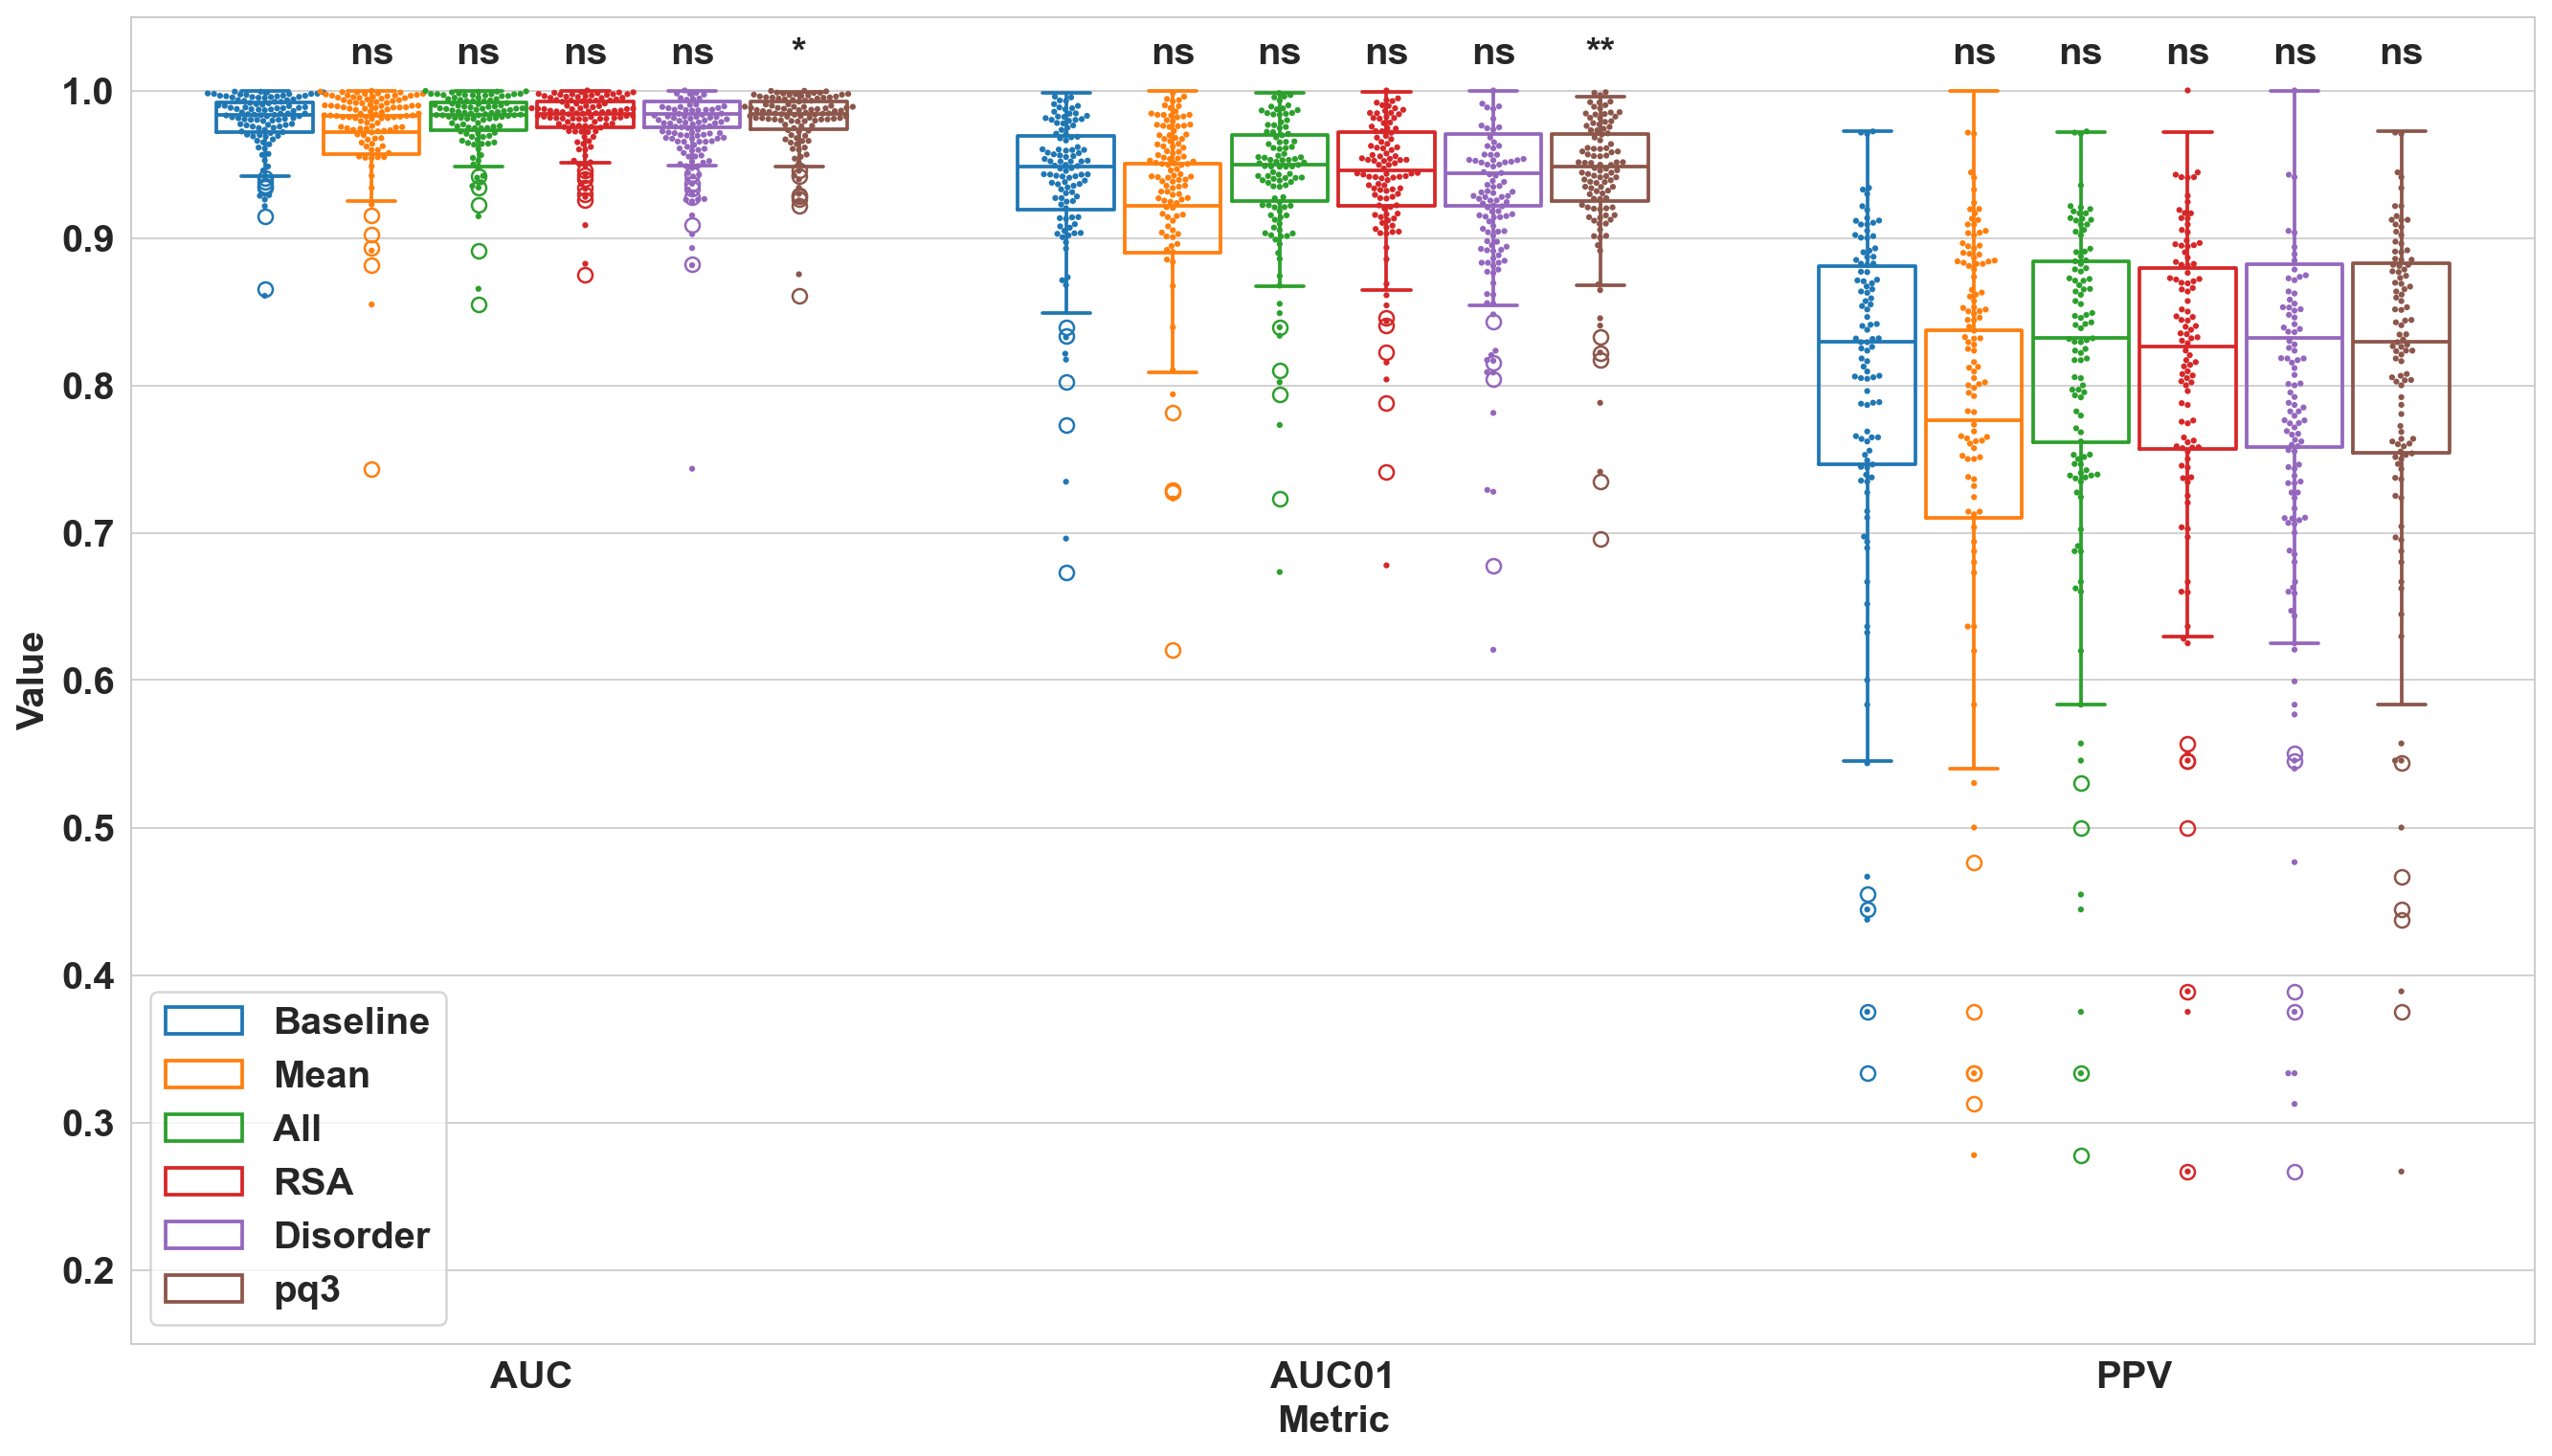

In [153]:
alpha=0.7
size=2.5
figsize=(18,10)
width=.8
saturation=1
swarm=True
fill=False
fn=None
mhc1_kcv_pvs, mhc1_kcv_sgs,_ = make_box(mhc1_kcv, figsize, saturation, alpha, width, size, swarm, fill, fn)
display(mhc1_kcv_sgs)

# Class I

## KCV (I)

,auc_pval,auc01_pval,ppv_pval
Mean,1.000000,1.000000,1.000000
All,0.994968,0.162239,0.578051
RSA,0.083722,0.083722,0.942766
Disorder,0.500000,0.162239,0.500000
pq3,0.024117,0.002768,0.975883


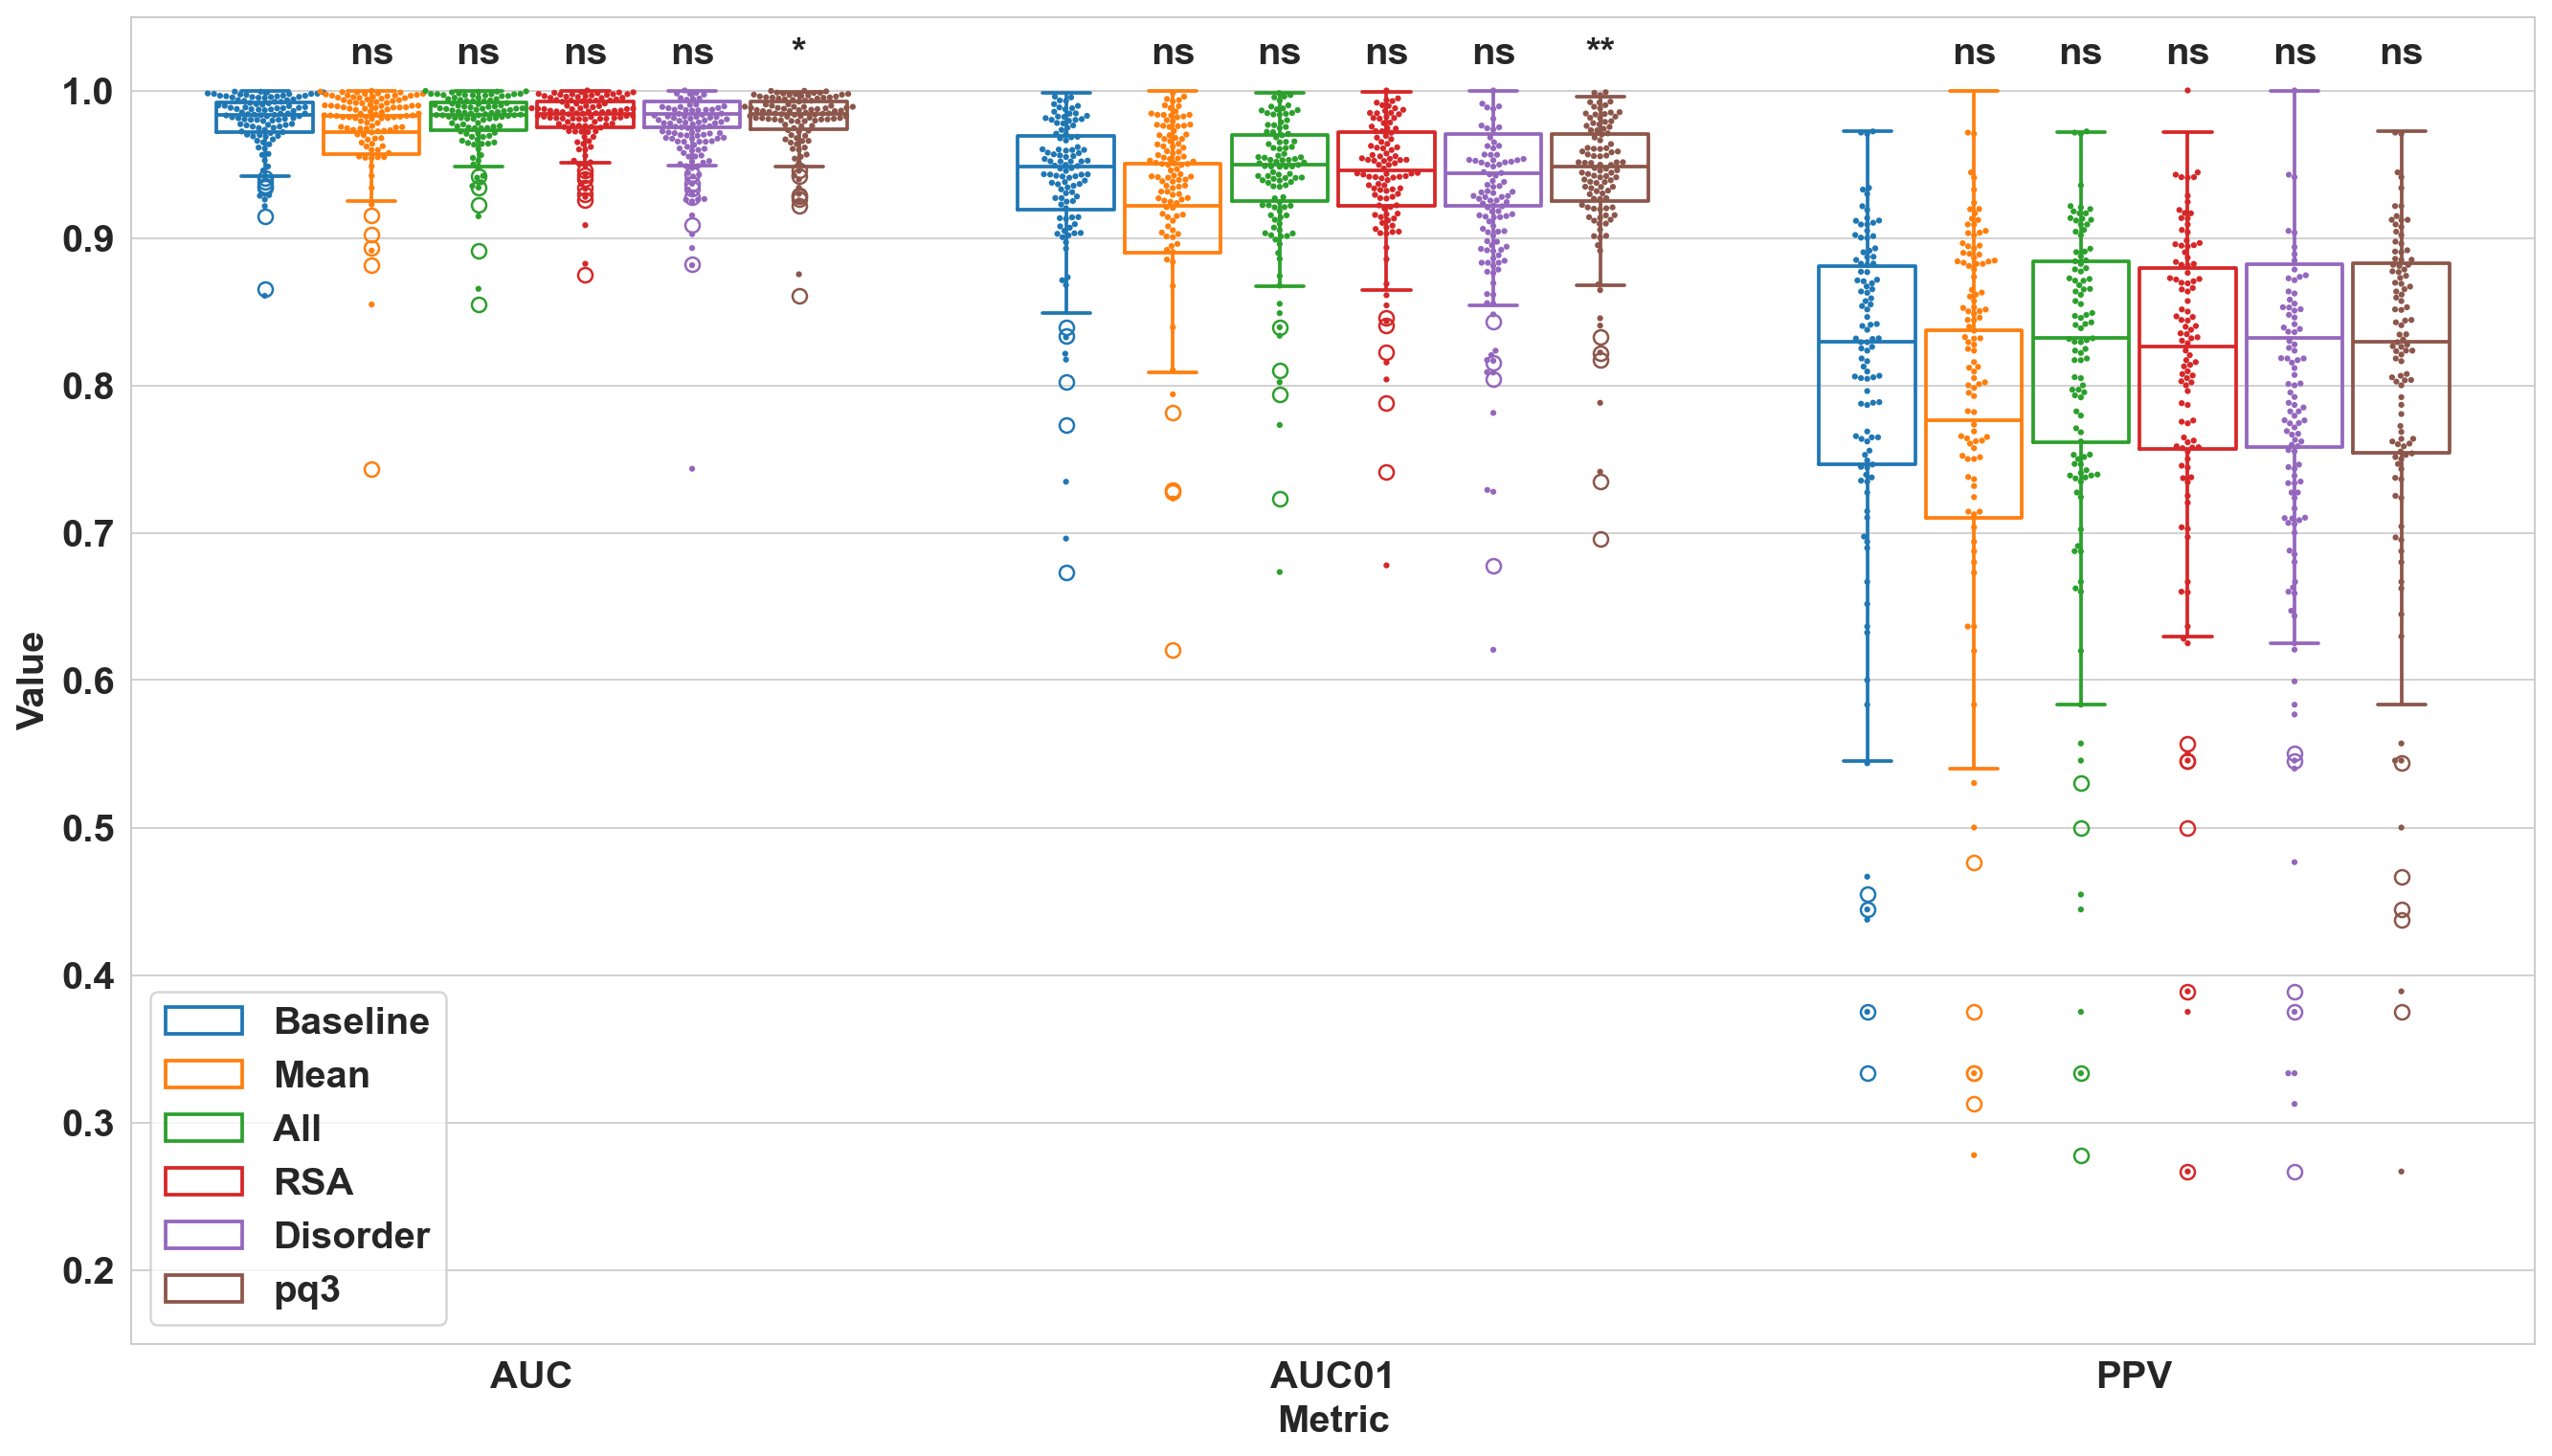

In [154]:
files = glob.glob(f'{DD}*MHCI_valid*')
fn='MHC1_KCV'
mhc1_kcv = pd.concat([read_result(f) for f in files])
mhc1_kcv_pvs, mhc1_kcv_sgs,_ = make_box(mhc1_kcv, figsize, saturation, alpha, width, size, swarm, fill, fn)
display(mhc1_kcv_pvs)

In [ ]:
mhc1_kcv-

## Test set (I)

,auc_pval,auc01_pval,ppv_pval
Mean,1.000000,1.000000,1.000000
All,0.087643,0.054428,0.990671
RSA,0.866094,0.356115,0.999995
Disorder,0.548921,0.730709,0.999995
pq3,0.945572,0.730709,0.982209


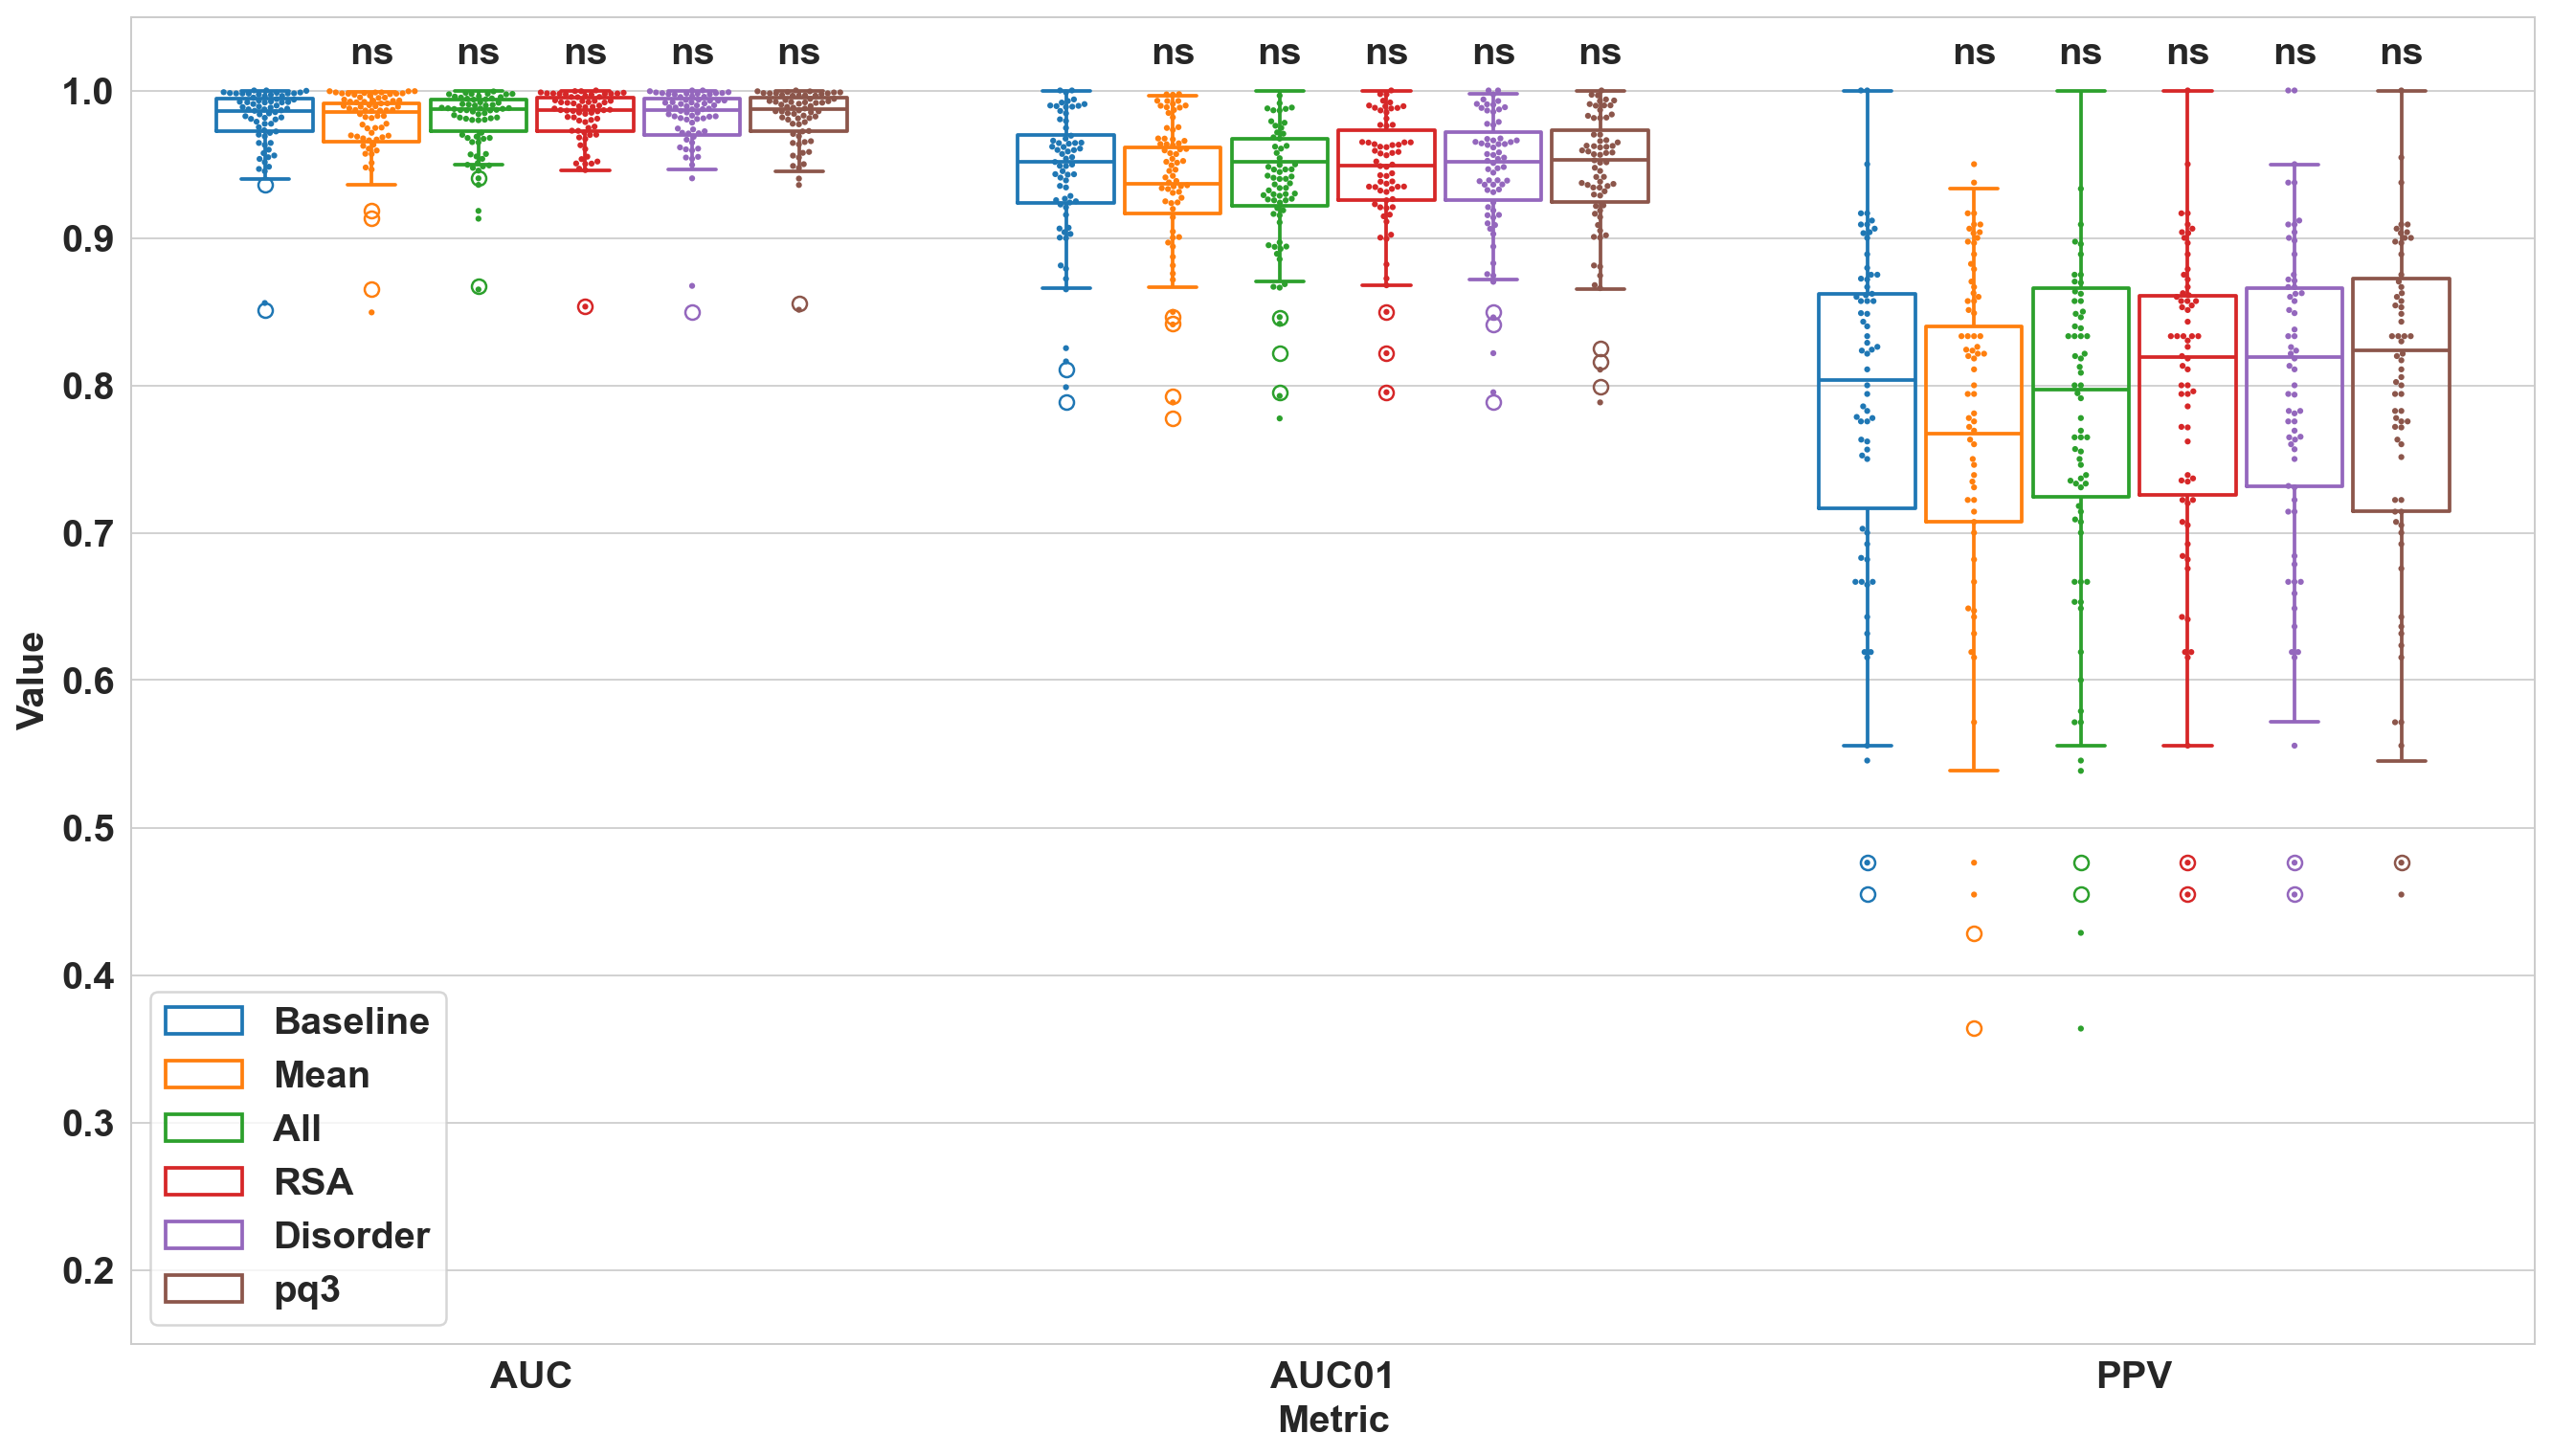

In [155]:
files = glob.glob(f'{DD}*MHCI_ensemble_test*')
fn='MHC1_Test'
mhc1_test = pd.concat([read_result(f) for f in files])
do_binom(mhc1_test)
mhc1_test_pvs, mhc1_test_sgs,_ = make_box(mhc1_test,  figsize, saturation, alpha, width, size, swarm, fill, fn)
display(mhc1_test_pvs)

# Class II

## KCV (II)

,auc_pval,auc01_pval,ppv_pval
Mean,1.000000,1.000000,1.000000
All,0.000008,0.000008,0.003958
RSA,0.044215,0.044215,0.082075
Disorder,0.044215,0.321984,0.139978
pq3,0.001444,0.021779,0.021779


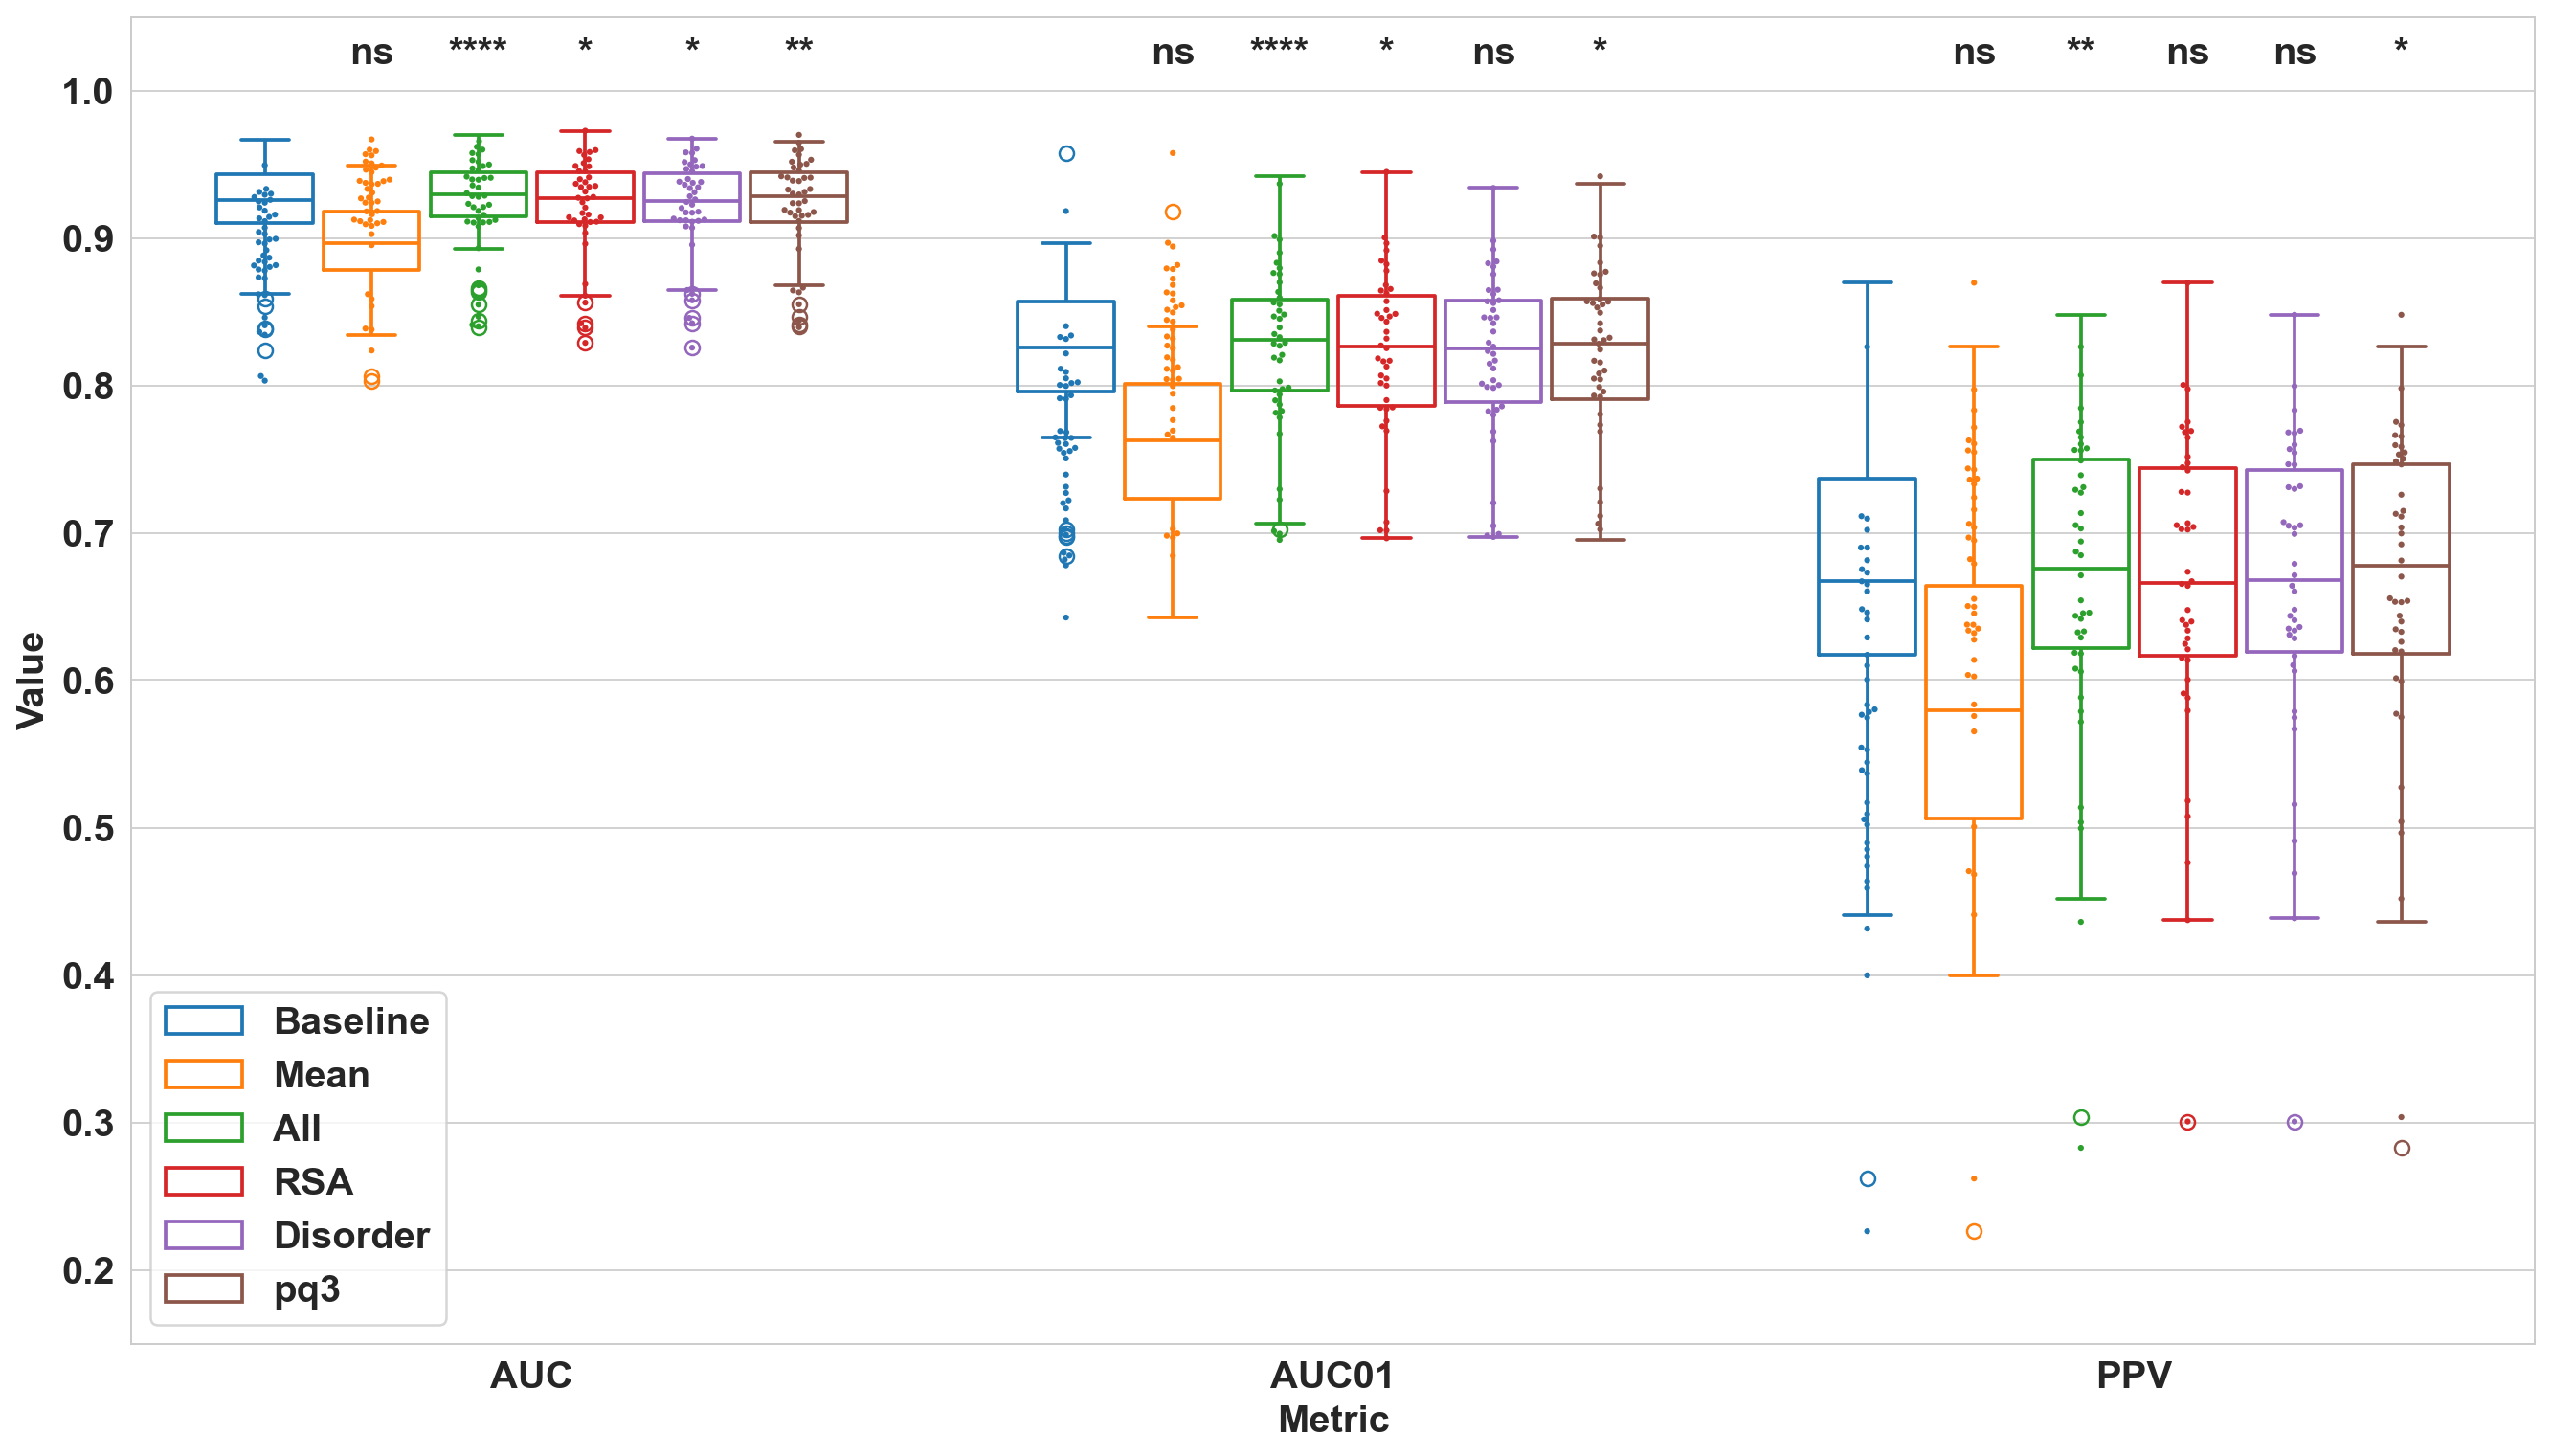

In [156]:
files = glob.glob(f'{DD}*DR_valid*')
fn='HLA-DR_KCV'
mhc2_kcv = pd.concat([read_result(f) for f in files])
mhc2_kcv_pvs, mhc2_kcv_sgs,_ = make_box(mhc2_kcv,  figsize, saturation, alpha, width, size, swarm, fill, fn)
display(mhc2_kcv_pvs)

## Test set (II)

,auc_pval,auc01_pval,ppv_pval
Mean,0.894488,1.000000,1.000000
All,0.058638,0.029792,0.029792
RSA,0.970208,0.733645,0.500000
Disorder,1.000000,0.999987,0.997838
pq3,0.266355,0.733645,0.500000


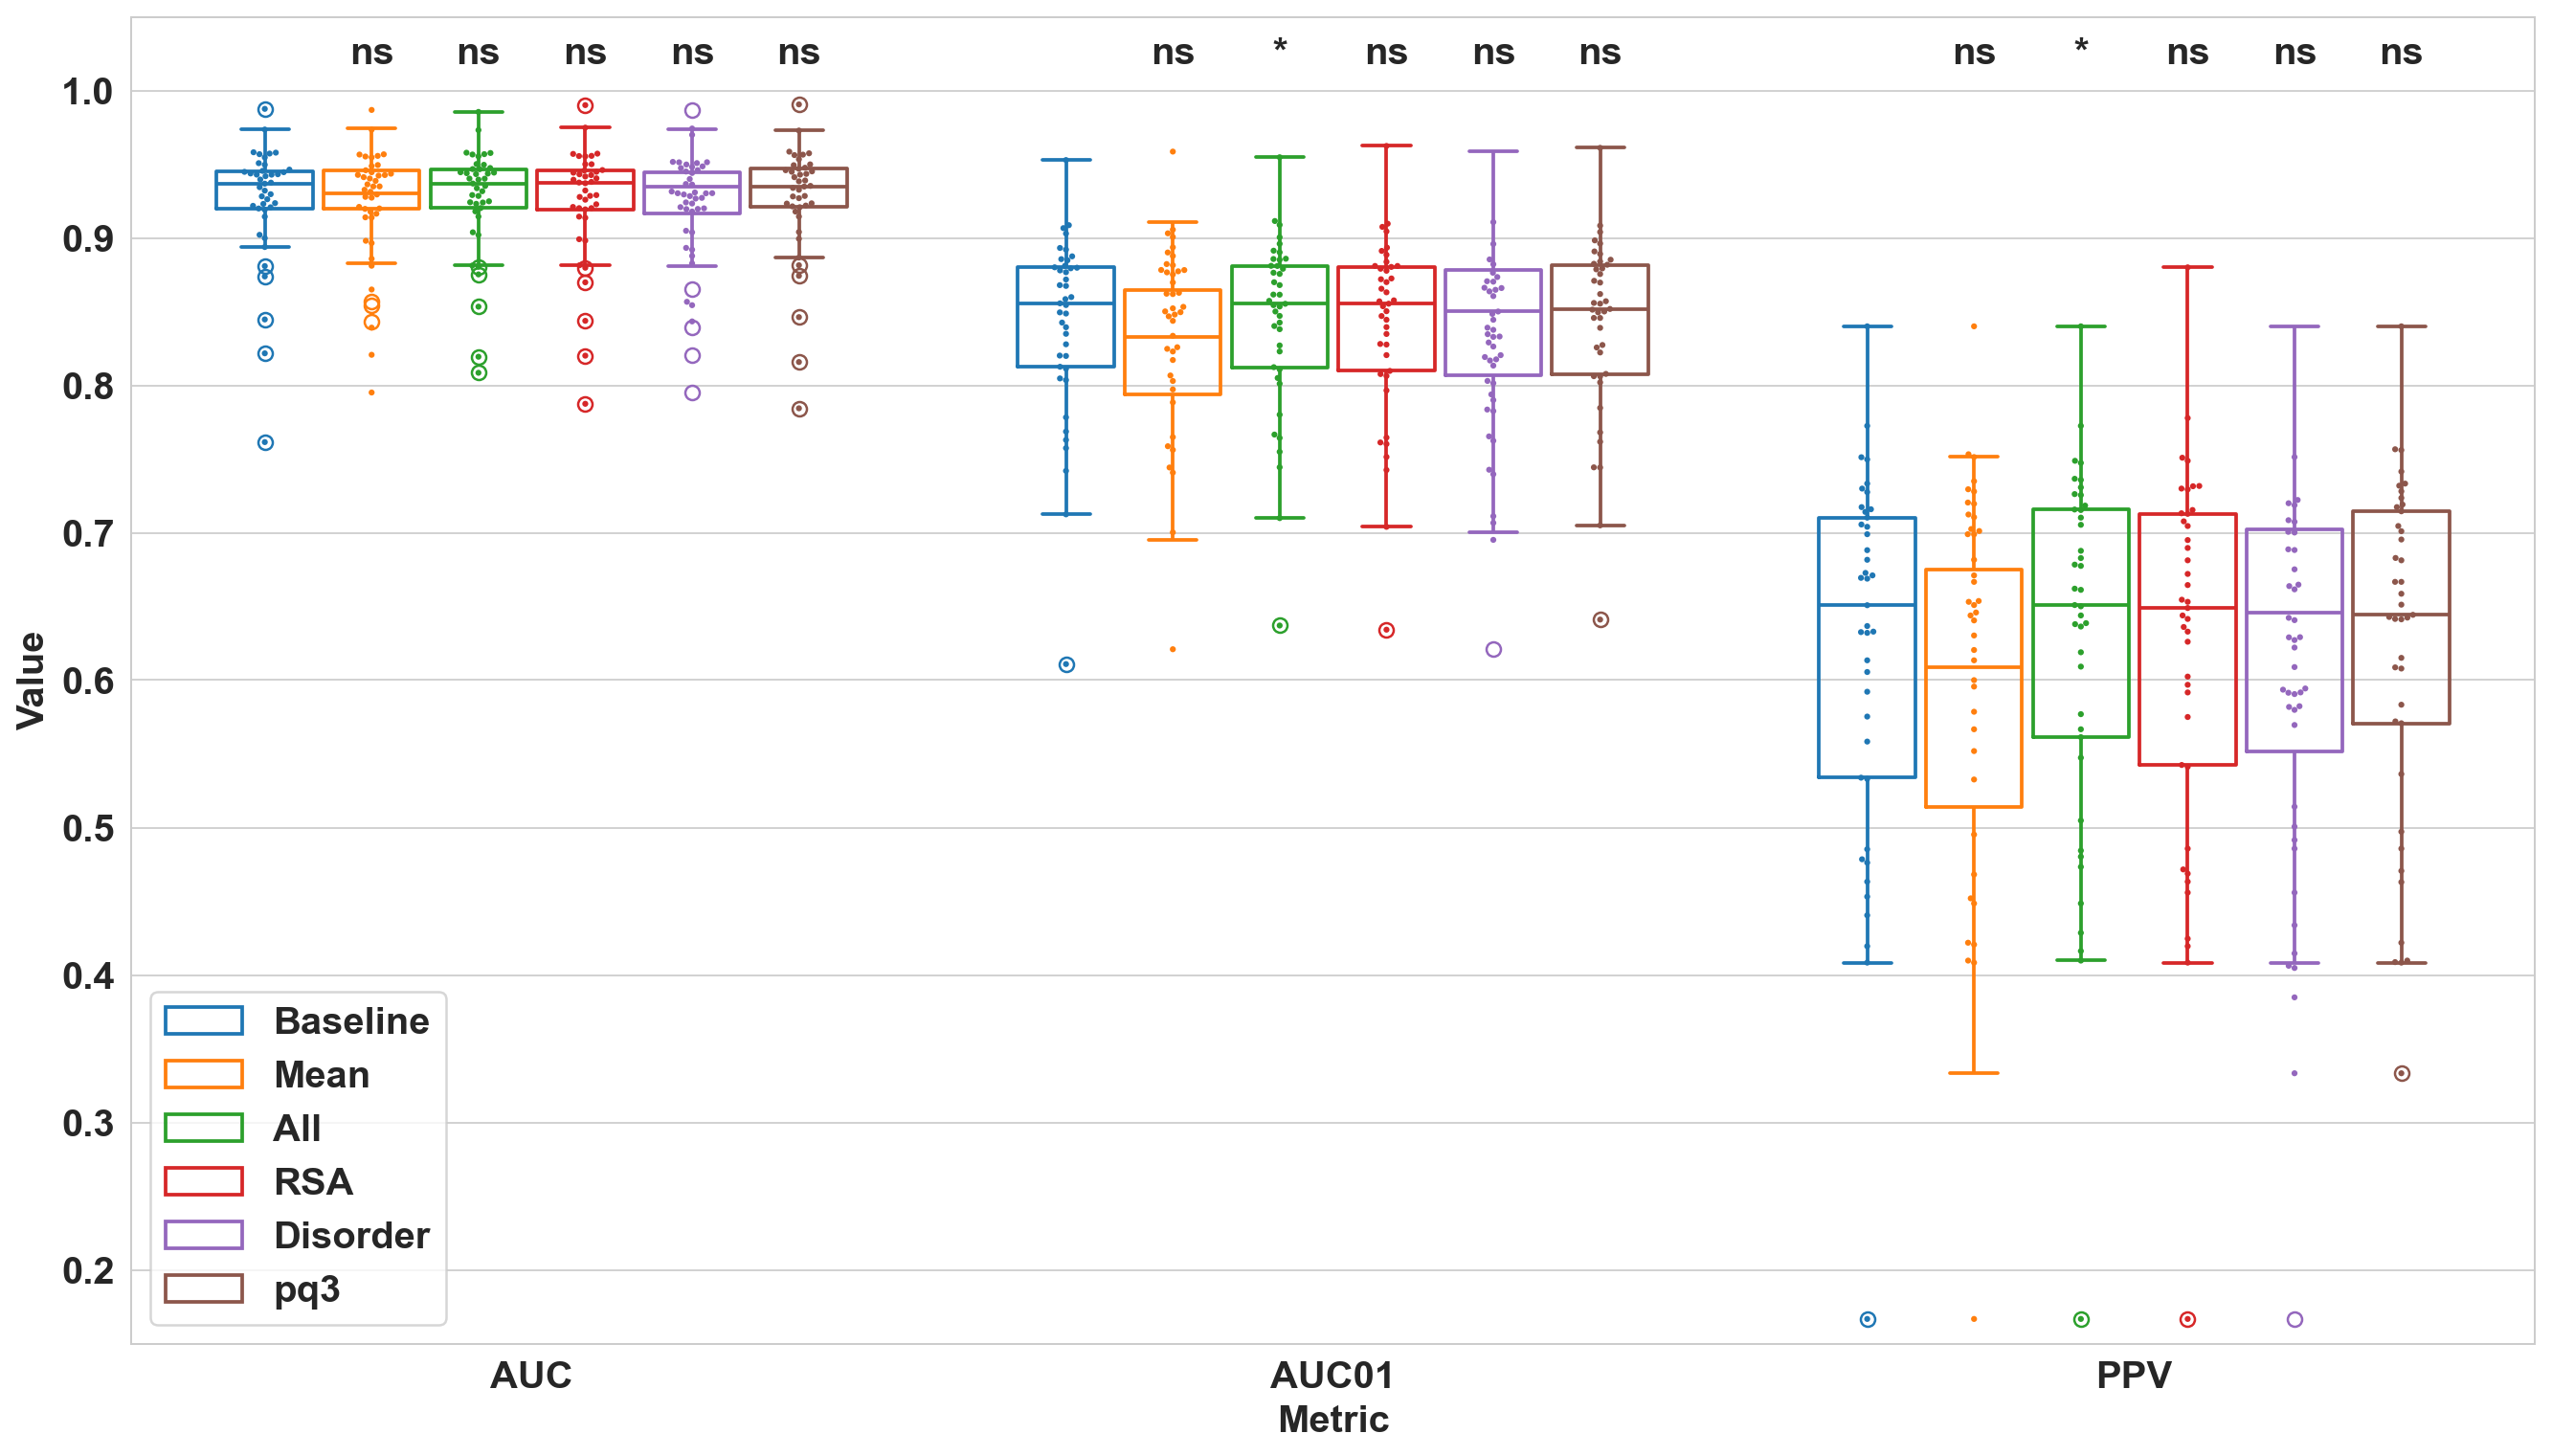

In [157]:
files = glob.glob(f'{DD}*DR_ensemble_test*')
mhc2_test = pd.concat([read_result(f) for f in files])
fn='HLA-DR_Test'
do_binom(mhc2_test)
mhc2_test_pvs, mhc2_test_sgs, _ = make_box(mhc2_test,  figsize, saturation, alpha, width, size, swarm, fill, fn)
display(mhc2_test_pvs)

In [197]:
a=mhc2_kcv.query('model=="baseline"').set_index('MHC')[['auc', 'auc01', 'ppv']]
b=mhc2_kcv.query('model=="pos_struct"').set_index('MHC')[['auc', 'auc01', 'ppv']]
(b>a).query('auc01')

,auc,auc01,ppv
MHC,,,
DRB1_0101,True,True,True
DRB1_0102,True,True,True
DRB1_0103,True,True,True
DRB1_0301,True,True,True
DRB1_0302,True,True,True
DRB1_0401,True,True,True
DRB1_0403,False,True,False
DRB1_0404,True,True,False
DRB1_0407,True,True,False


In [ ]:
# get enriched list (for Delta AUC01 > threshold) vs non enriched list
(b-a).query('auc01>2.5e-3').reset_index()['MHC'].to_csv(f'{DD}enriched_HLA_DR_testset_delta_AUC01_2.5e-3_allele_list.txt', header=False, index=False)
(b>a).query('not auc01').reset_index()['MHC'].to_csv(f'{DD}NOT_ENRICHED_HLA_DR_testset_allele_list.txt', header=False, index=False)
(b>a).query('auc01').reset_index()['MHC'].to_csv(f'{DD}enriched_HLA_DR_testset_all_delta_AUC01_allele_list.txt', header=False, index=False)

In [191]:
binomtest(26,41, alternative="greater")

BinomTestResult(k=26, n=41, alternative='greater', statistic=0.6341463414634146, pvalue=0.05863760297870613)

In [196]:
(d>c).apply(lambda x: binomtest(x.sum(), x.count(), alternative="greater").pvalue)

auc      0.058638
auc01    0.029792
ppv      0.029792
dtype: float64

In [182]:
c=mhc2_test.query('model=="baseline"').set_index('MHC')[['auc', 'auc01', 'ppv']]
d=mhc2_test.query('model=="pos_struct"').set_index('MHC')[['auc', 'auc01', 'ppv']]
(d>c).query('auc01')

,auc,auc01,ppv
MHC,,,
DRB1_0101,True,True,True
DRB1_0102,False,True,True
DRB1_0103,False,True,False
DRB1_0301,True,True,True
DRB1_0401,True,True,True
DRB1_0403,True,True,True
DRB1_0404,True,True,True
DRB1_0407,True,True,True
DRB1_0701,True,True,True


In [219]:
(d>c).query('auc01')

,auc,auc01,ppv
MHC,,,
DRB1_0101,True,True,True
DRB1_0102,False,True,True
DRB1_0103,False,True,False
DRB1_0301,True,True,True
DRB1_0401,True,True,True
DRB1_0403,True,True,True
DRB1_0404,True,True,True
DRB1_0407,True,True,True
DRB1_0701,True,True,True


In [220]:
len((d>c).query('auc01'))

27

In [236]:
# get enriched list (for Delta AUC01 > threshold) vs non enriched list
(d-c).query('auc01>2.5e-3').reset_index()['MHC'].to_csv(f'{DD}enriched_HLA_DR_testset_delta_AUC01_2.5e-3_allele_list.txt', header=False, index=False)
(d>c).query('not auc01').reset_index()['MHC'].to_csv(f'{DD}NOT_ENRICHED_HLA_DR_testset_allele_list.txt', header=False, index=False)
(d>c).query('auc01').reset_index()['MHC'].to_csv(f'{DD}enriched_HLA_DR_testset_all_delta_AUC01_allele_list.txt', header=False, index=False)